<a href="https://colab.research.google.com/github/samyff12/LATAM/blob/main/IMAE_LATAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Actualizacion IMAE LATAM**

### Paquetes y meses

In [1]:
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import requests
import urllib.request as urllib2
import re
!pip install pymupdf
!pip install tabula-py
import tabula as tb
import fitz  # this is pymupdf
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
!pip install XlsxWriter
from google.colab import files

     |████████████████████████████████| 8.7 MB 5.2 MB/s 
     |████████████████████████████████| 12.0 MB 103 kB/s 
     |████████████████████████████████| 149 kB 5.0 MB/s 


In [2]:
#html = requests.get('http://www.secmca.org/chart/?parent=Producci%C3%B3n&scid=2&cid=1&scsid=0&son=%C3%8Dndice%20Mensual%20de%20la%20Actividad%20Econ%C3%B3mica&url=11/14/3-13-50-17-4-52-161/39/265/19-258/444/' +
 #                   '20211-20212-20213-20214-20215-20216-20217-20218-20219-202110-202111-202112-20221-20222-20223-20224-20225-20226-20227-20228-20229-202210-202211-202212' +
 #                   '-&all_vars=2|IMAE,%20variaci%C3%B3n%20interanual')
#soup = BeautifulSoup(html.text,'lxml')
#table = soup.find_all('p', class_='text-right')
#tablec = soup.find_all('th', colspan='1')

#indicadores=[]
#paises =[]
#for i in range(len(table)):
 # ind = float(table[i].text)
#  pais = tablec[i].text
#  indicadores.append(ind)
 # paises.append(pais)

#imae_latam =  pd.DataFrame(indicadores,index = paises,columns = ['IMAE'])
#print(f'IMAE a {fecha}')
#imae_latam

In [3]:
meses = [0,[1,'Enero'],[2,'Febrero'],[3,'Marzo'],[4,'Abril'],[5,'Mayo'],[6,'Junio'],[7,'Julio'],[8,'Agosto'],
         [9,'Septiembre'],[10,'Octubre'],[11,'Noviembre'],[12,'Diciembre']]
mes3 = {'ene':'Enero','feb':'Febrero','mar':'Marzo','abr':'Abril','may':'Mayo','jun':'Junio','jul':'Julio',
        'ago':'Agosto','sep':'Septiembre','oct':'Octubre','nov':'Noviembre','dic':'Diciembre'}
meses_dict = {0:'none',1:'Enero',2:'Febrero',3:'Marzo',4:'Abril',5:'Mayo',6:'Junio',7:'Julio',8:'Agosto',
         9:'Septiembre',10:'Octubre',11:'Noviembre',12:'Diciembre'}
### import calendar

# d = dict((v,k) for k,v in enumerate(calendar.month_abbr))
# d

## Para obtener las series de todo el año 2021-2022


### **SECMCA**

html = requests.get('http://www.secmca.org/chart/?parent=Producci%C3%B3n&scid=2&cid=1&scsid=0&son=%C3%8Dndice%20Mensual%20de%20la%20Actividad%20Econ%C3%B3mica&url=11/14/3-13-50-17-4-52-161/39/265/19-258/444/' +
                    '20211-20212-20213-20214-20215-20216-20217-20218-20219-202110-202111-202112-20221-20222-20223-20224-20225-20226-20227-20228-20229-202210-202211-202212' +
                    '-&all_vars=2|IMAE,%20variaci%C3%B3n%20interanual').text
soup = BeautifulSoup(html,'lxml')

#### Publicaciones disponibles las fechas: 

#####    **El Salvador**
2. 29 Oct
3. 30 Nov
4. 23 Dic
5. 31 Ene

#####    **Panama**
3. 22 Nov
4. 21 Dic


#####    **Honduras**
-. Preliminar 20 de cada mes, con 50 días de rezago y
revisado 30 días después

In [4]:
# INDICE VERSION
html1 = requests.get('http://www.secmca.org/chart/?parent=Producci%C3%B3n&scid=2&cid=1&scsid=0&son=%C3%8Dndice%20Mensual%20de%20la%20Actividad%20Econ%C3%B3mica&url=11/14/3-13-50-17-4-52-161/39/265/19-258/81/' +
  '20201-20202-20203-20204-20205-20206-20207-20208-20209-202010-202011-202012-20211-20212-20213-20214-20215-20216-20217-20218-20219-202110-202111-202112-20221-20222-20223-20224-20225-20226-20227-20228-20229-202210-202211-202212' +
  '-&all_vars=1|IMAE').text
soup1 = BeautifulSoup(html1,'html.parser')

tabpais = soup1.find_all('th', colspan='1')
table = soup1.find_all('p', class_='text-left')
fechas = []
for i in range(len(table)):
  x = re.sub(" ","",table[i].text)
  fechas.append(x.replace("\n","").replace('Setiembre','Septiembre'))

paises = [tabpais[i].text for i in range(len(tabpais))]
fechas[-1]

'2021-Septiembre'

In [5]:
#INDICE
table1 = soup1.find_all('p', class_='text-right')
matriz = np.array([])
for i in table1:
  matriz = np.array(np.append(matriz,i))
matriz = np.where(matriz=="--", np.nan, matriz).astype(np.float)
matriz = matriz.reshape(-1,7) # 7 paises
imaeLA = pd.DataFrame(matriz,index=fechas,columns=paises)
imaeLA

,Costa Rica,El Salvador,Guatemala,Honduras,Nicaragua,República Dominicana,Panamá
2020-Enero,104.14,110.80,127.40,243.14,152.88,179.04,345.73
2020-Febrero,105.17,110.06,125.54,242.59,144.12,183.24,338.73
2020-Marzo,103.55,105.56,121.36,218.14,140.05,165.67,364.78
2020-Abril,90.88,88.28,112.77,186.13,124.67,125.35,247.19
2020-Mayo,93.10,89.88,111.25,188.45,133.85,158.43,228.30
2020-Junio,97.04,96.97,111.06,208.19,128.81,160.89,243.01
2020-Julio,92.92,96.05,117.42,208.83,147.58,162.35,241.95
2020-Agosto,93.36,102.57,120.25,225.70,138.50,169.07,251.35
2020-Septiembre,98.15,106.44,121.45,230.41,139.98,163.68,268.97
2020-Octubre,102.10,106.64,125.72,249.61,148.48,175.09,312.12


import re
tabpais = soup.find_all('th', colspan='1')
table = soup.find_all('p', class_='text-left')
fechas = []
paises =[]
for i in range(len(table)):
  x = re.sub(" ","",table[i].text)
  fechas.append(x.replace("\n",""))
  pais = tabpais[i].text
  #indicadores.append(ind)
  paises.append(pais)
fechas[-1]

table1 = soup.find_all('p', class_='text-right')
matriz = np.array([])
for i in table1:
  matriz = np.array(np.append(matriz,i))
matriz = np.where(matriz=="--", np.nan, matriz).astype(np.float)
matriz = matriz.reshape(-1,7) # 7 paises
imaeLA = pd.DataFrame(matriz,index=fechas,columns=paises)
imaeLA

### **Argentina**


#### Publicaciones disponibles las fechas: 
1. 28 sept 
2. 21 Oct
3. 23 Nov
4. 23 Dic

In [6]:
url = "https://www.indec.gob.ar/ftp/cuadros/economia/sh_emae_mensual_base2004.xls"
urllib2.urlretrieve(url, "test.xls")
data = pd.read_excel('test.xls',header=2)[2:]
data1 = data.iloc[:,:4].dropna(subset = [data.columns[1]]) # data.columns[1] es la columna de los meses
data1.reset_index(drop=True,inplace=True)
data1[data1.columns[0]] = data1[data1.columns[0]].ffill() # forward fill # para los años   data1.columns[0] es la columna de los años
data1.iloc[:,:3]

,Período,Unnamed: 1,Índice Serie Original\n2004=100
0,2004,Enero,92.627506
1,2004,Febrero,90.186179
2,2004,Marzo,101.883298
3,2004,Abril,102.567430
4,2004,Mayo,109.877504
...,...,...,...
207,2021,Abril,144.940980
208,2021,Mayo,150.194265
209,2021,Junio,148.854057
210,2021,Julio,143.287754


In [7]:
data1['fecha'] = data1[data1.columns[0]].astype('str') +"-"+ data1[data1.columns[1]]
data1.set_index(data1.fecha,inplace=True)
data1.iloc[:,2].tail(1)

fecha
2021-Agosto    141.215168
Name: Índice Serie Original\n2004=100, dtype: float64

In [8]:
imaeLA = pd.merge(imaeLA,data1.iloc[:,2],how='left',left_index=True,right_index=True)
imaeLA.columns = [*imaeLA.columns[:-1], 'Argentina']
imaeLA.tail(1)

,Costa Rica,El Salvador,Guatemala,Honduras,Nicaragua,República Dominicana,Panamá,Argentina
2021-Septiembre,NaN,NaN,NaN,NaN,NaN,180.96,NaN,NaN


### **Brasil**

#### Publicaciones :
1. 15 sept
2. 15 Oct
3. 16 Nov
4. 15 Dic

In [9]:
urljson = "https://api.bcb.gov.br/dados/serie/bcdata.sgs.24363/dados?formato=json"
urllib2.urlretrieve(urljson, "brasil.json")
bra = pd.read_json('brasil.json')
bra.rename(columns={'valor':'Brasil'},inplace=True)

bra['Brasil1'] = bra.Brasil.pct_change(12)*100 # calculo tasa de crecimiento
bra['date'] = pd.to_datetime(bra['data'],format='%d/%m/%Y') # transformamos a formato fecha
# Creamos indice
bra['fecha'] = pd.DatetimeIndex(bra['date']).year.astype(str) +"-"+pd.DatetimeIndex(bra['date']).month.astype(str)

nombre_mes = [meses[i][1] for i in pd.DatetimeIndex(bra['date']).month.tolist()] # obtenemos nombre del mes
bra['fecha'] = pd.DatetimeIndex(bra['date']).year.astype(str) +"-"+ nombre_mes # creamos indice
bra.set_index(bra.fecha,inplace=True) #reemplazamos indice

imaela = pd.merge(imaeLA,bra['Brasil'],how='left',left_index=True,right_index=True) # combinamos la data
bra.tail(1)

,data,Brasil,Brasil1,date,fecha
fecha,,,,,
2021-Agosto,01/08/2021,141.93,4.737658,2021-08-01,2021-Agosto


In [10]:
 #    imaela

### **Mexico**

#### Publicaciones disponibles las fechas: 
1. 27 sept 
2. 25 Oct
3. 25 Nov
4. 24 Dic

In [11]:
url = "https://www.inegi.org.mx/contenidos/temas/economia/cn/igae/tabulados/ori/IGAE_1.xlsx"
urllib2.urlretrieve(url, "test.xlsx")
mex = pd.read_excel('test.xlsx',header=3,nrows=3)
mex = mex.T.reset_index(drop=True) # transponemos y estandarizamos el indice
mex.drop(0,inplace=True) # borramos primera fila
mex[2] = round(mex[2].astype(float),2) # leyendo tasas de crecimiento en el formato numerico y redondeando
mex[0] = mex[0].ffill()

In [12]:
mex[1] = mex[1].replace(['oR','oP','lR','lP','eR','eP'],['o','o','l','l','e','e'], regex=True) #limpiar superindices "Revisado" "Preliminar"
mex[0] = mex[0].replace('P','',regex=True) # limpiar preliminar de fecha
mex.index = mex[0].astype('str') +"-"+ mex[1] #creamos indice para base de datos
mex.columns = [*mex.columns[:-1], 'México'] # nombramos columna
mex.dropna().tail(1) # mostrar ultimo valor no nulo

,0,1,México
2021-Agosto,2021,Agosto,107.05


In [13]:
imaela = round(pd.merge(imaela,mex['México'],how='left',left_index=True,right_index=True),2) # combinamos las series

In [14]:
imaela

,Costa Rica,El Salvador,Guatemala,Honduras,Nicaragua,República Dominicana,Panamá,Argentina,Brasil,México
2020-Enero,104.14,110.80,127.40,243.14,152.88,179.04,345.73,132.28,133.72,111.90
2020-Febrero,105.17,110.06,125.54,242.59,144.12,183.24,338.73,129.75,134.77,108.32
2020-Marzo,103.55,105.56,121.36,218.14,140.05,165.67,364.78,129.10,136.84,109.83
2020-Abril,90.88,88.28,112.77,186.13,124.67,125.35,247.19,111.90,119.25,87.89
2020-Mayo,93.10,89.88,111.25,188.45,133.85,158.43,228.30,131.29,119.91,89.31
2020-Junio,97.04,96.97,111.06,208.19,128.81,160.89,243.01,133.30,126.29,97.82
2020-Julio,92.92,96.05,117.42,208.83,147.58,162.35,241.95,128.19,135.84,101.96
2020-Agosto,93.36,102.57,120.25,225.70,138.50,169.07,251.35,125.17,135.51,102.65
2020-Septiembre,98.15,106.44,121.45,230.41,139.98,163.68,268.97,126.60,137.12,102.92
2020-Octubre,102.10,106.64,125.72,249.61,148.48,175.09,312.12,131.73,139.74,109.17


In [15]:
## link excel
#https://www.inegi.org.mx/contenidos/temas/economia/cn/igae/tabulados/ori/IGAE_1.xlsx       indice

#https://www.inegi.org.mx/contenidos/temas/economia/cn/igae/tabulados/ori/IGAE_2.xlsx       crecimiento

### **Perú**

#### Publicaciones disponibles a fecha:
 
2. 21 Oct
3. 18 Nov
4. 

In [16]:
url = 'https://www.inei.gob.pe/media/principales_indicadores/CalculoPBI_98.zip' #cambio de 97 a 98 (jul ago)

In [17]:
zip, _ = urllib2.urlretrieve(url)
with zipfile.ZipFile(zip, "r") as f:
    f.extractall('/content')

In [18]:
indicador = [f.namelist()[i] for i in range(len(f.namelist())) if 'Indicador Mensual' in f.namelist()[i]][0] # el 0 es para que elija el string de la lista
df = pd.read_excel(indicador,sheet_name=1,header=3)[1:] # el indice esta en la segunda hoja del excel

In [19]:
indicador

'Indicador Mensual de la Producción Nacional 08 2021 r.xlsx'

In [20]:
pe = round(df.filter(like='Índice Global'),2)   # regex='spike|spke' se puede usar regex para en caso de que escriban las columnas mal
pe['YM'] = df['Año y Mes'].astype(int).astype(str)

#  IG.1 Mensual   IG.2 Acumulado  IG.3 Anual
pe['fecha'] =  pe['YM'].str[0:4] +'-'+ pe['YM'].str[4:7].astype(int).map(meses_dict)  # fecha
pe.set_index('fecha',inplace=True)

pe.rename(columns={pe.columns[0]:'Perú',pe.columns[1]:'Perú_i',pe.columns[2]:'Perú_a'},inplace=True)

In [21]:
imaela = imaela.merge(pe['Perú'],how='left',left_index=True,right_index=True)

### **Chile**

#### Publicaciones disponibles las fechas:
 
2. 1 Oct  - Agosto
3. 2 Nov  - Septiembre
4. 1 Dic - Noviembre

In [22]:
url = "https://si3.bcentral.cl/estadisticas/Principal1/excel/CCNN/IMACEC/Excel/IMACEC.xlsx"
urllib2.urlretrieve(url, "chile.xlsx")
df = pd.read_excel('chile.xlsx',header=5,keep_default_na=False)

In [23]:
chile = df.loc[1:,[df.columns[0],df.columns[1],'Imacec']][:-10] # excluimos las ultimas 10 filas (pie de pagina)
chile.rename(columns = {'Imacec':'Chile'}, inplace = True) # renombramos
chile['Chile1'] = pd.to_numeric(chile.Chile).pct_change(12)*100
###
chile[chile.columns[0]] = pd.to_numeric(chile[chile.columns[0]], errors='coerce').ffill().bfill().astype(int)
 # las columnas del excel contienen string en blanco por lo que se transformaron a numero antes de hacer el forward fill
 # el backward fill es para asegurar que no quede NaN por detras y dificulte la creacion del indice
###

chile['mes'] = chile[chile.columns[1]].map(mes3).bfill() # creando mes y usando el bfill por el mismo motivo explicado arriba

#Creamos el indice
chile.index = chile[chile.columns[0]].astype('str') +"-"+ chile.mes

chile.tail(1)

,,Unnamed: 1,Chile,Chile1,mes
2021-Agosto,2021,ago,120.345,19.075623,Agosto


In [24]:
 pd.to_numeric(chile[chile.columns[0]], errors='coerce')

2013-Enero     2013
2014-Enero     2014
2015-Enero     2015
2016-Enero     2016
2017-Enero     2017
               ... 
2021-Abril     2021
2021-Mayo      2021
2021-Junio     2021
2021-Julio     2021
2021-Agosto    2021
Name:  , Length: 113, dtype: int64

In [25]:
imaelatam = round(imaela.merge(chile['Chile'],how='left',left_index=True,right_index=True),2)
imaelatam = imaelatam[~imaelatam.index.duplicated(keep='last')].reindex(imaela.index) # hay duplicados, los eliminamos y reindexamos

In [26]:
#  imaelatam

### **Ecuador**

#### Publicaciones disponibles las fechas: 
1. 14 sept    -    Julio
2. 13 Oct    -     Agosto
3. 15 Nov    -     Sep
4. 24 Dic    -     Oct

In [27]:
url = "https://contenido.bce.fin.ec/documentos/PublicacionesNotas/Catalogo/IEMensual/Adelantos/IEM-452-e.xlsx"
urllib2.urlretrieve(url, "Ecuador.xlsx")
df = pd.read_excel('Ecuador.xlsx',header=7,keep_default_na=False)[1:13].reset_index()

ecu = (df.set_index(['Unnamed: 0','index'])
.stack()
.reset_index()
.rename(columns={'Unnamed: 0':'mes','level_2':'Year'})).sort_values(['Year','index']) # ingenieria de base de datos

# Elaboracion de indice
ecu['Mes'] = ecu.mes.str.lower().map(mes3)
ecu.insert(3, 'fecha', ecu.Year.astype(str) + '-' + ecu.Mes)
ecu.index = ecu.fecha

# Variacion interanual
ecu.rename(columns={0:'Ecuador'},inplace=True)
ecu['Ecuador1'] = pd.to_numeric(ecu['Ecuador'],errors='coerce').pct_change(12)*100

In [28]:
imaela = round(pd.merge(imaelatam,ecu['Ecuador'],how='left',left_index=True,right_index=True),2)

In [29]:
#   imaela

df = np.array(tb.read_pdf('ecuador.pdf',pages = '5',stream=True,multiple_tables=True,pandas_options={'header':None}))
dff = pd.DataFrame(df.reshape(-1,5)) # en 2022 el reshape debe ser (-1,6)

dff[dff.iloc[3,2].split(' ')] = dff[2].str.split(' ',expand=True)
if dff.iloc[3,3] in range(2020,2040,1):
  dff[int(dff.iloc[3,3])] = dff[3]
  dff[int(dff.iloc[3,4])] = dff[4]
else:
  dff[int(dff.iloc[3,4])] = dff[4]

if dff.iloc[18,0] in ['Ene']:
    ecu = dff.iloc[18:30,[0,-3,-2,-1]].reset_index(drop=True)
else:
    ecu = dff.iloc[19:31,[0,-3,-2,-1]].reset_index(drop=True)
 
ecu['interanualAnterior'] = ecu.iloc[:,-2].astype(float)/ecu.iloc[:,-3].astype(float)*100-100
ecu['Ecuador'] = ecu.iloc[:,-2].astype(float)/ecu.iloc[:,-3].astype(float)*100-100

listames = [meses[1:][i][1] for i in range(len(meses[1:]))]
ecu['mes'] = listames

ecu.index = str(ecu.columns[-4]) + '-' + ecu.mes
ecu.dropna().tail(1)

### **Colombia**

#### Publicaciones disponibles las fechas: 
1. 17 sept    -    Julio
2. 19 Oct    -     Agosto
3. 16 Nov    -     Sep
4. 17 Dic    -     Oct

In [30]:
url = 'https://www.dane.gov.co/index.php/estadisticas-por-tema/cuentas-nacionales/indicador-de-seguimiento-a-la-economia-ise/historicos-ise-comunicados-y-boletines'
url1 = 'https://www.dane.gov.co/index.php/estadisticas-por-tema/cuentas-nacionales/indicador-de-seguimiento-a-la-economia-ise'
header= {'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) ' 
      'AppleWebKit/537.11 (KHTML, like Gecko) '
      'Chrome/23.0.1271.64 Safari/537.11',
      'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8',
      'Accept-Charset': 'ISO-8859-1,utf-8;q=0.7,*;q=0.3',
      'Accept-Encoding': 'none',
      'Accept-Language': 'en-US,en;q=0.8',
      'Connection': 'keep-alive'}

req = urllib2.Request(url=url1, headers=header) 
page = urllib2.urlopen(req).read()


In [31]:
soupco = BeautifulSoup(page,'lxml')
links = [a['href'] for a in soupco.select("a[href*=21.xlsx]")] # extraemos links que contengan 21.xlsx 
 # ultimos link disponibles
links

['/files/investigaciones/boletines/pib/Anex_ISE_9actividades_ago_21.xlsx',
 '/files/investigaciones/boletines/pib/Anex_ISE_12_actividades_II_trimestre_21.xlsx']

In [32]:
url2 = 'https://www.dane.gov.co' + links[0] # si esta el nuevo mes restarle 1 al indice de links
urllib2.urlretrieve(url2, "colombia.xlsx")
df = pd.read_excel('colombia.xlsx',sheet_name='Cuadro 1',header=9)[0:16].T
df.columns = df.iloc[0]
df = df.iloc[:,[0,1,-1]].reset_index(drop=True)[1:]
df.tail(1)

Unnamed: 0,Concepto,NaN,Indicador de Seguimiento a la Economía
200,NaN,Agosto,114.935


In [33]:
df['ano'] = df.Concepto.ffill().astype(str).str.replace('pr','').str.replace('p','')
df['Colombia'] = round(pd.to_numeric(df.loc[:,df.columns[-2]]),2)
df.index = df.ano.astype(str) + '-' + df.iloc[:,1].astype(str) 

In [34]:
imaela = imaela.merge(df['Colombia'],how='left',left_index=True,right_index=True)

##### PDF

df = np.array(tb.read_pdf('colombia.pdf',pages = '17',stream=True,multiple_tables=True,pandas_options={'header':None}))
dco = pd.DataFrame(df.reshape(-1,4))
dco = dco.loc[:,0:2]
dco.tail(1)

dco[3] = dco[2].str.split(' ',expand=True)[0] # Tomando las tasas de crecimiento de la tabla pdf
dco.rename(columns={1:'Colombia'},inplace=True)
dco['Colombia1'] = pd.to_numeric(dco[3].str.replace(',','.'),errors='coerce')  #Convirtiendo la data a numero
dco['Colombia'] = pd.to_numeric(dco['Colombia'].str.replace(',','.'),errors='coerce')

split = dco[0].str.split(' - ')     # extraer mes 
fech = []
for i in range(len(split)):
  if type(split[i]) == float:
    fech.append('0')
  elif len(split[i]) == 1 :
    fech.append(str(split[i][0]))
  else:
    fech.append(str(split[i][1].capitalize()))

anof=[]                          # extraer año
for i in range(len(split)):
  if type(split[i]) == float:
    anof.append('0')
  elif len(split[i]) > 1 :
    anof.append(str(split[i][0]))
  else:
    anof.append(np.nan)

dco['mes'] = fech
dco['ano'] = anof
dco['ano'] = dco.ano.replace(['p','r',' '],['','',''],regex=True).ffill()
dco.index = dco['ano'] + '-' + dco['mes'] # creamos indice

### **Bolivia**

#### Publicaciones disponibles las fechas:
 
2. 
3. 
4.

In [35]:
urlbol = 'https://www.ine.gob.bo/index.php/estadisticas-economicas/indice-global-de-actividad-economica-igae/#1584545313102-06cf787f-a790'
req = urllib2.Request(url=urlbol, headers=header) 
page = urllib2.urlopen(req).read()

In [36]:
soupbol = BeautifulSoup(page,'lxml')
links = [a['href'] for a in soupbol.select("a[href*=nube.ine.gob.bo/index.php]")] # extraemos links que contengan nube.ine.gob
 # ultimos link disponibles
links # IGAE por actividad economica es el segundo

['https://nube.ine.gob.bo/index.php/s/lhzNu4ISQEuXS1M/download',
 'https://nube.ine.gob.bo/index.php/s/6Szm6RmYSBeRnsD/download',
 'https://nube.ine.gob.bo/index.php/s/qNQexpgoZroGCYG/download',
 'https://nube.ine.gob.bo/index.php/s/vsfGqiIoEXGddwJ/download',
 'https://nube.ine.gob.bo/index.php/s/k0bRzzNhBXb7Ae2/download']

In [37]:
urllib2.urlretrieve(links[1], "Bolivia.xlsx")
#https://nube.ine.gob.bo/index.php/s/6Szm6RmYSBeRnsD/download

('Bolivia.xlsx', <http.client.HTTPMessage at 0x7f5e4c69f850>)

In [38]:
df = pd.read_excel('Bolivia.xlsx',header=12)
df

,Unnamed: 0,ACTIVIDAD ECONÓMICA,2008,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.10,2009,0.11,0.12,0.13,0.14,0.15,0.16,0.17,0.18,0.19,0.20,0.21,2010,0.22,0.23,0.24,0.25,0.26,0.27,0.28,0.29,0.30,0.31,0.32,2011,0.33,...,0.112,0.113,0.114,0.115,0.116,0.117,0.118,0.119,0.120,2019(p),Unnamed: 135,Unnamed: 136,Unnamed: 137,Unnamed: 138,Unnamed: 139,Unnamed: 140,Unnamed: 141,Unnamed: 142,Unnamed: 143,Unnamed: 144,Unnamed: 145,2020(p),Unnamed: 147,Unnamed: 148,Unnamed: 149,Unnamed: 150,Unnamed: 151,Unnamed: 152,Unnamed: 153,Unnamed: 154,Unnamed: 155,Unnamed: 156,Unnamed: 157,2021(p),Unnamed: 159,Unnamed: 160,Unnamed: 161,Unnamed: 162,Unnamed: 163,Unnamed: 164
0,NaN,0,Ene,Feb,Mar,Abr,May,Jun,Jul,Ago,Sep,Oct,Nov,Dic,Ene,Feb,Mar,Abr,May,Jun,Jul,Ago,Sep,Oct,Nov,Dic,Ene,Feb,Mar,Abr,May,Jun,Jul,Ago,Sep,Oct,Nov,Dic,Ene,Feb,...,Abr,May,Jun,Jul,Ago,Sep,Oct,Nov,Dic,Ene,Feb,Mar,Abr,May,Jun,Jul,Ago,Sep,Oct,Nov,Dic,Ene,Feb,Mar,Abr,May,Jun,Jul,Ago,Sep,Oct,Nov,Dic,Ene,Feb,Mar,Abr,May,Jun,Jul
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,INDICE GENERAL,173.165,167.186,190.983,207.587,206.503,204.062,201.218,193.403,202.011,207.98,199.808,198.816,178.47,173.294,195.237,211.581,210.363,209.806,206.191,199.9,212.185,216.774,209.699,208.202,183.889,177.813,202.915,216.94,219.621,219.081,211.361,206.225,223.631,228.558,220.018,221.999,197.77,190.959,...,318.341,311.481,316.978,303.283,313.251,332.875,340.116,324.8,330.364,293.122,275.729,310.469,325.198,319.066,327.553,312.055,318.072,340.411,347.506,315.463,342.838,304.943,277.363,297.958,234.039,231.828,266.589,268.308,274.025,311.836,346.259,336.104,340.282,291.746,266.627,311.444,301.902,286.118,295.427,300.994
3,NaN,"AGRICULTURA, PECUARIO, SILVICULTURA, CAZA Y PESCA",114.154,133.013,235.046,264.551,206.841,189.984,146.091,130.307,173.488,175.218,151.904,115.131,119.019,138.957,243.322,274.195,214.183,202.078,154.216,133.536,180.319,180.58,155.16,115.118,119.236,138.575,240.64,269.445,212.569,200.127,147.136,130.853,180.553,182.527,149.694,114.459,124.322,144.404,...,368.85,276.442,300.005,217.103,198.479,261.252,282.465,244.011,165.821,164.466,203.182,388.559,393.654,290.364,315.834,226.969,211.263,282.377,293.46,250.734,174.342,168.301,205.752,402.372,418.356,293.444,313.936,234.962,223.176,293.738,301.004,258.967,181.16,171.921,212.081,406.899,426.38,299.939,324.832,240.748
4,NaN,PETRÓLEO CRUDO Y GAS NATURAL,302.075,272.682,296.243,264.613,297.104,293.51,308.602,319.11,306.933,327.963,308.631,296.223,239.785,223.32,238.548,220.618,288.823,292.686,289.379,284.945,265.626,266.783,276.614,222.109,231.628,245.194,280.329,229.184,301.828,306.984,317.888,339.517,324.143,321.814,358.392,286.032,275.372,285.908,...,328.011,403.251,397.708,409.609,417.227,405.882,392.772,334.502,255.741,307.856,325.728,254.399,235.296,321.804,341.005,351.005,357.418,352.572,401.514,432.891,310.942,370.037,262.953,264.832,169.261,253.783,306.557,334.324,345.217,329.451,356.934,407.28,330.404,338.047,268.448,326.008,264.99,332.018,338.194,333.985
5,NaN,MINERALES METÁLICOS Y NO METÁLICOS,175.222,174.546,180.244,196.643,204.11,220.446,245.68,222.697,238.973,210.159,227.192,201.962,209.755,221.048,206.039,224.483,228.98,232.75,260.868,244.537,236.811,237.263,230.9,211.66,215.235,191.487,238.698,187.95,264.069,236.853,239.724,190.802,232.156,234.917,195.258,206.129,254.347,230.598,...,243.879,270.376,260.695,246.441,248.492,288.46,239.103,282.243,230.615,271.859,230.704,243.482,237.714,279.063,268.501,264.155,202.536,253.644,217.221,216.349,267.547,255.985,227.128,165.735,13.2386,67.2885,200.767,155.909,144.381,197.233,213.916,238.408,230.382,227.177,208.863,229.395,241.874,267.989,242.559,264.634
6,NaN,INDUSTRIA MANUFACTURERA,177.093,159.27,165.051,186

In [39]:
df.set_index(df.iloc[:,1],inplace=True)
df = df.iloc[:-3,2:] # eliminar primera columna y ultimas 3 filas
df = df.T.reset_index()

In [40]:
# PARA EXTRAER AÑO DE COLUMNA INDEX
df['index'] = df['index'].astype(str).str.replace('\(p\)','')
df['index'] = df['index'].str.replace('^0.[0-9]','nan')      # reemplaza los numeros decimales regex que empiece por 0. y le siga cualquier num
df['index'] = df['index'].str.replace('^0$','nan')    # reemplaza toda fila con 0 como unico digito
df['index'] = pd.to_numeric(df['index'],errors='coerce').ffill().astype(int)

In [41]:
df['fecha'] = df['index'].astype(str) +'-'+ df[0].str.lower().map(mes3) # columna fecha
df.set_index('fecha',inplace=True)
df.rename(columns={df.columns[3]:'Bolivia'},inplace=True)

In [42]:
imaela = imaela.merge(df['Bolivia'],how='left',left_index=True,right_index=True)

In [43]:
imaela

,Costa Rica,El Salvador,Guatemala,Honduras,Nicaragua,República Dominicana,Panamá,Argentina,Brasil,México,Perú,Chile,Ecuador,Colombia,Bolivia
2020-Enero,104.14,110.80,127.40,243.14,152.88,179.04,345.73,132.28,133.72,111.90,162.69,109.984,166.081,105.38,304.943
2020-Febrero,105.17,110.06,125.54,242.59,144.12,183.24,338.73,129.75,134.77,108.32,161.66,106.315,151.878,105.60,277.363
2020-Marzo,103.55,105.56,121.36,218.14,140.05,165.67,364.78,129.10,136.84,109.83,138.05,113.427,142.951,96.71,297.958
2020-Abril,90.88,88.28,112.77,186.13,124.67,125.35,247.19,111.90,119.25,87.89,103.81,98.4788,101.926,81.90,234.039
2020-Mayo,93.10,89.88,111.25,188.45,133.85,158.43,228.30,131.29,119.91,89.31,119.30,97.793,117.005,91.93,231.828
2020-Junio,97.04,96.97,111.06,208.19,128.81,160.89,243.01,133.30,126.29,97.82,140.35,96.1215,132.598,96.15,266.589
2020-Julio,92.92,96.05,117.42,208.83,147.58,162.35,241.95,128.19,135.84,101.96,154.69,96.1001,141.261,98.56,268.308
2020-Agosto,93.36,102.57,120.25,225.70,138.50,169.07,251.35,125.17,135.51,102.65,157.76,101.066,143.837,101.56,274.025
2020-Septiembre,98.15,106.44,121.45,230.41,139.98,163.68,268.97,126.60,137.12,102.92,162.76,103.167,152.052,103.87,311.836
2020-Octubre,102.10,106.64,125.72,249.61,148.48,175.09,312.12,131.73,139.74,109.17,171.17,108.477,156.349,111.30,346.259


### **Paraguay**

In [44]:
url = 'https://www.bcp.gov.py/indicador-mensual-de-actividad-economica-del-paraguay-imaep-i471'
urlpy = 'https://www.bcp.gov.py/anexo-estadistico-del-informe-economico-i365'
#the URL where you are requesting at
req = urllib2.Request(url=urlpy, headers=header) 
page = urllib2.urlopen(req).read()

In [45]:
souppy = BeautifulSoup(page,'lxml')
links = [a['href'] for a in souppy.select("a[href*=.xlsx]")] # extraemos links que contengan 2021 
 # ultimos link disponibles
links

['userfiles/files/Anexo_Estad%C3%ADstico%20del%20Informe%20Econ%C3%B3mico_28_10_2021.xlsx']

In [60]:
url2py = 'https://www.bcp.gov.py/' + links[0]
req2 = requests.get(url2py, headers = header)  # nueva forma de descargar excel file de pagina de py

In [61]:
import datetime
dfpy = pd.read_excel(req2.content,sheet_name='CUADRO 9',header=9).iloc[:-3,1:] # con limpieza iloc CUADRO 9 es IMAEP
dfpy.rename(columns={dfpy.columns[1]:"Paraguay"},inplace=True)

In [62]:
# FECHA COLUMNA
dfpy['A'] = pd.DatetimeIndex(dfpy[dfpy.columns[0]]).year
dfpy['M'] = pd.DatetimeIndex(dfpy[dfpy.columns[0]]).month.map(meses_dict)
dfpy['fecha'] = dfpy.A.astype(str) + "-" + dfpy.M.astype(str)
dfpy.set_index('fecha',inplace=True)

In [63]:
imaela = imaela.merge(dfpy['Paraguay'],how='left',left_index=True,right_index=True)

In [ ]:
imaela


url2 = 'https://www.bcp.gov.py/' + links[0] # -(numero mes)
opener = urllib2.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib2.install_opener(opener)
urllib2.urlretrieve(url2, "py.pdf")




'With pdf file

with fitz.open("py.pdf") as doc:
    text = ""
    for page in doc:
        text += page.get_text()

fechapy = text.split(' |',2)[1] # con el espacio
fechapy = fechapy.split(' ')[1] +'-'+fechapy.split(' ')[0]

Debido a que las tasas son iguales en Enero

if 'Enero' not in fechapy:
  valorpyinteranual = re.findall(r'[0-9]+,[0-9]+',text)[0] # para obtener tasa interanual          el regex sirve para buscar los registros numericos separados por coma
  valorpyacum = re.findall(r'[0-9]+,[0-9]+',text)[1] # para obtener tasa acumulada interanual
  valorpyinteranual = float(valorpyinteranual.replace(',','.'))
  valorpyacum = float(valorpyacum.replace(',','.'))
else:
   valorpyinteranual = re.findall(r'[0-9]+,[0-9]+',text)[0]
   valorpyinteranual = float(valorpyinteranual.replace(',','.'))
   valorpyacum = valorpyinteranual

print(fechapy)
print(valorpyinteranual,' Tasa interanual')
print(valorpyacum, ' Tasa acumulada interanual')


py = pd.DataFrame({'Fecha':['2021-Enero','2021-Febrero','2021-Marzo','2021-Abril','2021-Mayo','2021-Junio','2021-Julio','2021-Agosto','2021-Septiembre','2021-Octubre','2021-Noviembre','2021-Diciembre'],
                   'Paraguay_a':[-5.6,-3.0,0.7,4.7,6.3,6.3,6.0,5.7,0,0,0,0],
                   'Paraguay_i':[-5.6,-0.5,8.0,19.3,12.4,6.6,3.0,4.2,0,0,0,0]})
py.index = py.Fecha
dic = {'Fecha':fechapy,'Paraguay_a':valorpyacum,'Paraguay_i':valorpyinteranual}
py.loc[fechapy] = [fechapy,valorpyacum,valorpyinteranual]
py

In [66]:
imaela['a'] = [imaela.index.str.split('-')[i][0] for i in range(len(imaela.index))]
imaela = imaela.apply(pd.to_numeric)

In [68]:
# Crecimiento interanual
imaela1 = imaela.pct_change(12,fill_method=None)*100
imaela1.dropna(how='all',inplace=True) # NAs drop
imaela1.drop('a',axis=1,inplace=True)

In [69]:
# Crecimiento acumulado interanual
imaela2 = imaela.groupby('a').cumsum().pct_change(12,fill_method=None)*100
imaela2.dropna(how='all',inplace=True) # NAs drop

In [70]:
#!pip install selenium
#!apt-get update # to update ubuntu to correctly run apt install
#!apt install chromium-chromedriver
#!cp /usr/lib/chromium-browser/chromedriver /usr/bin
#import sys
#sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')
#from selenium import webdriver
#chrome_options = webdriver.ChromeOptions()
#chrome_options.add_argument('--headless')
#chrome_options.add_argument('--no-sandbox')
#chrome_options.add_argument('--disable-dev-shm-usage')
#wd = webdriver.Chrome('chromedriver',chrome_options=chrome_options)

## imae


In [71]:
imaela.drop('a',axis=1).tail(2)

,Costa Rica,El Salvador,Guatemala,Honduras,Nicaragua,República Dominicana,Panamá,Argentina,Brasil,México,Perú,Chile,Ecuador,Colombia,Bolivia,Paraguay
2021-Agosto,105.63,NaN,129.34,255.65,151.16,188.83,317.68,141.22,141.93,107.05,176.43,120.345,168.50691,114.93,NaN,112.984361
2021-Septiembre,NaN,NaN,NaN,NaN,NaN,180.96,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [72]:
writer = pd.ExcelWriter('imae_latam.xlsx', engine='xlsxwriter')

imaela1.to_excel(writer, sheet_name='Interanual')
imaela2.to_excel(writer, sheet_name='Acumulado')
imaela.to_excel(writer, sheet_name='Indices - Serie Original')
writer.save()

files.download("imae_latam.xlsx")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

writer = pd.ExcelWriter('farm_data.xlsx', engine='xlsxwriter')
df.to_excel(writer, sheet_name='Sheet1')

workbook = writer.book
worksheet = writer.sheets['Sheet1']

chart = workbook.add_chart({'type': 'column'})

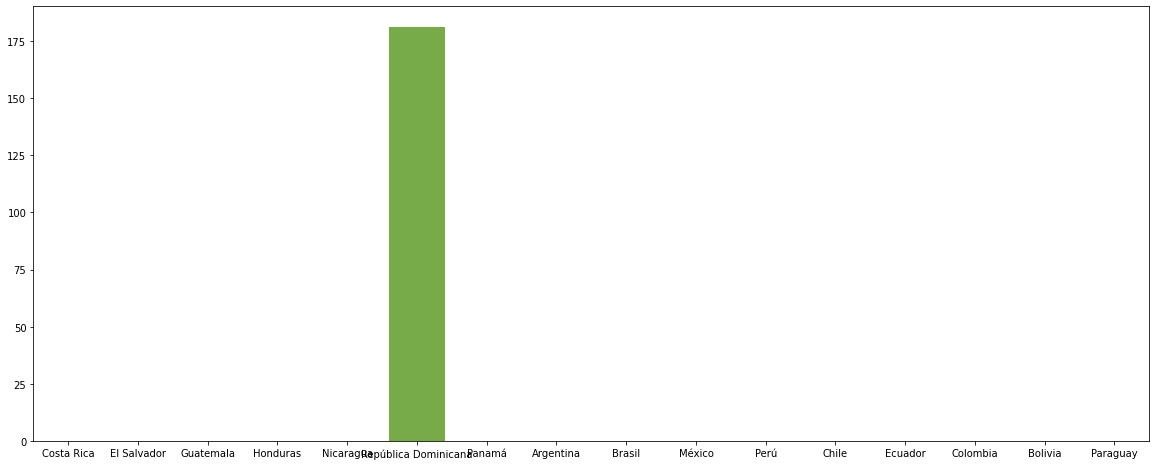

In [73]:
#@title Bar
f, ax = plt.subplots(figsize=(20, 8))
sns.barplot(data=imaela.drop('a',axis=1).iloc[-1:,:]);

In [ ]:
#@title Interanual Mes Anterior
f, ax = plt.subplots(figsize=(18, 8))
df = pd.melt(imaela1.iloc[-2:-1,:]).sort_values('value',ascending=False) 
sns.barplot(data = df ,x='value',y='variable',
                palette=['r' if y =='República Dominicana' else '#0343DF' for y in df.variable])
for p in ax.patches:
    width = p.get_width()    # get bar length
    ax.text(width+0.2,       # set the text at 0.2 unit right of the bar
            p.get_y() + p.get_height() / 2, # get Y coordinate + X coordinate / 2
            '{:1.2f}'.format(width), # set variable to display, 2 decimals
            ha = 'left',   # horizontal alignment
            va = 'center', weight="bold") # vertical alignment
plt.title('IMAE LATAM \n Crecimiento Interanual (%) {}'.format(imaela.index[-2]),weight='bold');

In [ ]:
#@title Acumulado Interanual Mes Anterior
f, ax = plt.subplots(figsize=(18, 8))
df = pd.melt(imaela2.iloc[-2:-1,:]).sort_values('value',ascending=False) 
sns.barplot(data = df ,x='value',y='variable',
                palette=['r' if y =='República Dominicana' else '#0343DF' for y in df.variable])
for p in ax.patches:
    width = p.get_width()    # get bar length
    ax.text(width+0.2,       # set the text at 0.2 unit right of the bar
            p.get_y() + p.get_height() / 2, # get Y coordinate + X coordinate / 2
            '{:1.2f}'.format(width), # set variable to display, 2 decimals
            ha = 'left',   # horizontal alignment
            va = 'center', weight="bold") # vertical alignment
plt.title('IMAE LATAM \n Crecimiento Acumulado Interanual (%) a {}'.format(imaela.index[-2]) ,weight='bold');

In [ ]:
#@title Interanual Ultimo Mes
f, ax = plt.subplots(figsize=(18, 8))
df = pd.melt(imaela1.iloc[-1:,:].dropna(axis=1)).sort_values('value',ascending=False) 
sns.barplot(data = df ,x='value',y='variable',
                palette=['r' if y =='República Dominicana' else '#0343DF' for y in df.variable])
for p in ax.patches:
    width = p.get_width()    # get bar length
    ax.text(width+0.2,       # set the text at 0.2 unit right of the bar
            p.get_y() + p.get_height() / 2, # get Y coordinate + X coordinate / 2
            '{:1.2f}'.format(width), # set variable to display, 2 decimals
            ha = 'left',   # horizontal alignment
            va = 'center', weight="bold") # vertical alignment
plt.title('IMAE LATAM \n Crecimiento Interanual (%) {}'.format(imaela.index[-1]),weight='bold')
;

In [ ]:
#@title Acumulado Interanual Ultimo Mes
f, ax = plt.subplots(figsize=(18, 8))
df = pd.melt(imaela2.iloc[-1:,:].dropna(axis=1)).sort_values('value',ascending=False) 
sns.barplot(data = df ,x='value',y='variable',
                palette=['r' if y =='República Dominicana' else '#0343DF' for y in df.variable])
for p in ax.patches:
    width = p.get_width()    # get bar length
    ax.text(width+0.2,       # set the text at 0.2 unit right of the bar
            p.get_y() + p.get_height() / 2, # get Y coordinate + X coordinate / 2
            '{:1.2f}'.format(width), # set variable to display, 2 decimals
            ha = 'left',   # horizontal alignment
            va = 'center', weight="bold") # vertical alignment
plt.title('IMAE LATAM \n Crecimiento Acumulado Interanual (%) a {}'.format(imaela.index[-1]) ,weight='bold');